In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import strategies
from optimization.genetic import optimize
from storage.database import Hdf5Client
from datetime import datetime
from utils.utils import resample_timeframe
from plots import Plot

In [8]:
from_date = int(datetime(2021, 1, 1).timestamp() * 1000)
to_date = int(datetime(2021, 7, 1).timestamp() * 1000)
today = int(datetime(2021, 12, 31).timestamp() * 1000)


db = Hdf5Client('binance')

data = db.get_data('BTCUSDT', from_date, to_date).sort_index()

db.hf.close()

df = resample_timeframe(data, '30m')

In [3]:
df.head()

,open,high,low,close,volume
timestamp,,,,,
2020-12-31 23:00:00,29123.18,29133.36,28936.00,29026.04,2911.893
2020-12-31 23:30:00,29026.04,29026.06,28800.00,28951.68,3996.627
2021-01-01 00:00:00,28948.19,29045.93,28706.00,28859.28,5397.275
2021-01-01 00:30:00,28860.00,29055.00,28859.99,29015.00,2640.313
2021-01-01 01:00:00,29015.00,29499.00,28975.46,29437.41,13012.064


In [4]:
df.tail()

,open,high,low,close,volume
timestamp,,,,,
2021-06-30 20:00:00,34744.91,35116.60,34744.90,34920.00,15821.846
2021-06-30 20:30:00,34920.00,35066.20,34360.00,34569.25,18080.849
2021-06-30 21:00:00,34569.26,34980.00,34569.24,34834.96,11374.074
2021-06-30 21:30:00,34834.97,35000.00,34666.00,34798.98,12485.388
2021-06-30 22:00:00,34798.99,34838.74,34754.38,34781.69,322.796


In [5]:
optimiation_results = optimize('binance', 'BTCUSDT', 'sma', '1h', from_date, to_date, 5, 5)
optimiation_results

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


[PNL = 121.28 Max. Drawdown = 15.7 Parameters = {'slow_ma': 78, 'fast_ma': 7} Rank = 0 Crowding Distance = inf,
 PNL = 140.04 Max. Drawdown = 20.9 Parameters = {'slow_ma': 92, 'fast_ma': 3} Rank = 0 Crowding Distance = 2.0,
 PNL = 140.47 Max. Drawdown = 21.35 Parameters = {'slow_ma': 92, 'fast_ma': 4} Rank = 0 Crowding Distance = inf,
 PNL = 47.75 Max. Drawdown = 25.56 Parameters = {'slow_ma': 200, 'fast_ma': 2} Rank = 1 Crowding Distance = inf,
 PNL = 106.4 Max. Drawdown = 28.2 Parameters = {'slow_ma': 92, 'fast_ma': 7} Rank = 1 Crowding Distance = inf]

In [6]:
strategies = reload(strategies)

In [9]:
strategy = strategies.Sma(**optimiation_results[2].parameters)
strategy.set_target('binance', 'BTCUSDT', '1h', to_date, today)

In [10]:
df = resample_timeframe(data, '1h')

In [11]:
trades = strategy.trade_history(df)

trades.head()

,position,enter_at,exit_at,open,close,pnl,log-returns,log-cum-returns,cum-returns
0,1,2021-07-04 18:00:00,2021-07-05 12:00:00,35534.66,33363.28,-0.061106,-0.063053,-0.063053,0.938894
1,-1,2021-07-05 12:00:00,2021-07-06 07:00:00,33363.28,34662.21,-0.038933,-0.039711,-0.102764,0.902340
2,1,2021-07-06 07:00:00,2021-07-06 12:00:00,34662.21,34037.01,-0.018037,-0.018202,-0.120965,0.886065
3,-1,2021-07-06 12:00:00,2021-07-07 06:00:00,34037.01,34796.05,-0.022300,-0.022553,-0.143518,0.866305
4,1,2021-07-07 06:00:00,2021-07-07 22:00:00,34796.05,34225.06,-0.016410,-0.016546,-0.160064,0.852089


In [12]:
df[df == trades.iloc[0]['close']].dropna(how='all')

,open,high,low,close,volume
timestamp,,,,,


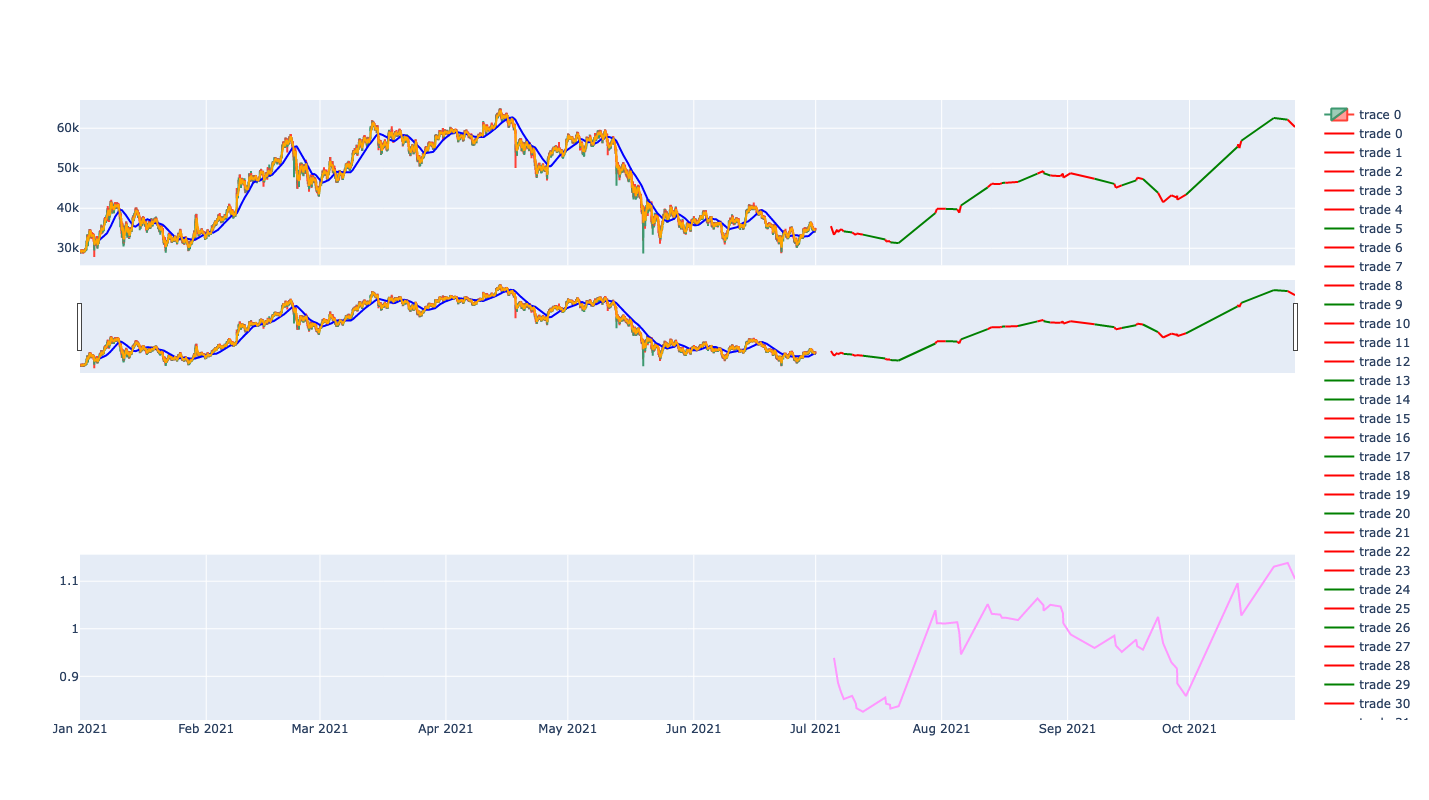

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

subfig = Plot(df).plot()
subfig.add_traces(strategy.get_trades())
subfig.add_traces(strategy.get_indicators(df))

for trace in subfig.data:
    fig.add_trace(trace)
    
fig.add_trace(
    go.Scatter(x=trades['exit_at'], y=trades['cum-returns']),
    row=3, col=1
)
fig.update_layout(height=800)
fig.show()

<AxesSubplot:>

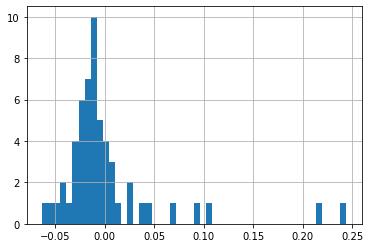

In [15]:
trades['log-returns'].hist(bins=50)